---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 3. Use it to complete the assignment by following the instructions provided in each section. Each section includes a text cell outlining the requirements. For additional details, refer to Canvas.

Use this first cell to import the necessary libraries.

In [ ]:
# create more cells if necessary
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim


# 1. **Data Management**


In this part, you need to:

1.  define your experimental protocol (such as k-fold, cross validation, etc);
2.	create the dataloader to load the data.



In [ ]:
# Load dataset.
def load_data(filepath):
  """
  A function to load the NER dataset.
  Input: filepath where the dataset is located.
  Returns: list of sentences and tags.
  """
  sentences, tags = [], []
  sentence, tag_seq = [], []

  with open(filepath, 'r') as f:
      for line in f:
          line = line.strip()
          if line:
              word, tag = line.split()
              sentence.append(word)
              tag_seq.append(tag)
          else:
              if sentence:
                  sentences.append(sentence)
                  tags.append(tag_seq)
                  sentence, tag_seq = [], []

  return sentences, tags

# Load the dataset.
sentences, tags = load_data("assignment3-ner_dataset.txt")

In [ ]:
# First split of data: 90% train data, 10% test data.
train_sentences, test_sentences, train_tags, test_tags = train_test_split(
    sentences, tags, test_size=0.1, random_state=42) # sentences and tags are now defined and can be split

# Second split: splitting the training data into 90% training and 10% validation
train_sentences, val_sentences, train_tags, val_tags = train_test_split(
    train_sentences, train_tags, test_size=0.1, random_state=42)

# print the sizes of each set.
print(f"Training set size: {len(train_sentences)}")
print(f"Validation set size: {len(val_sentences)}")
print(f"Test set size: {len(test_sentences)}")


Training set size: 1373
Validation set size: 153
Test set size: 170


In [ ]:
#  Create vocabularies from training set.
word_counter = Counter(w for s in train_sentences for w in s)
word_vocab = {w: idx+2 for idx, w in enumerate(word_counter)}
word_vocab['<PAD>'] = 0
word_vocab['<UNK>'] = 1

tag_vocab = {tag: idx for idx, tag in enumerate(sorted({t for seq in tags for t in seq}))}

# Encoding sentences and tags using integers.
def encode_data(sentences, tags, word_vocab, tag_vocab):
  """
  A function to encode sentences and tags.
  Input: setences, tags, word_vocab, tag_vocab.
  Returns: Encoded tags and sentences.
  """
  # Words not found in word vocab are replaced with <UNK>.
  encoded_sents = [[word_vocab.get(w, word_vocab['<UNK>']) for w in sent] for sent in sentences]
  # Tag strings into tag indicies.
  encoded_tags = [[tag_vocab[t] for t in tag_seq] for tag_seq in tags]
  return encoded_sents, encoded_tags

# Apply the encoding to each set: train, test and validation.
encoded_train_sents, encoded_train_tags = encode_data(train_sentences, train_tags, word_vocab, tag_vocab)
encoded_val_sents, encoded_val_tags = encode_data(val_sentences, val_tags, word_vocab, tag_vocab)
encoded_test_sents, encoded_test_tags = encode_data(test_sentences, test_tags, word_vocab, tag_vocab)


In [ ]:
class NERDataset(Dataset):
    """
    A class for a custom dataset for NER.
    Input: Dataset.
    """
    def __init__(self, sentences, tags):
        """
        A function to initialise the dataset.
        Input: Encoded sentences and tags.
        """
        self.sentences = sentences
        self.tags = tags

    def __len__(self):
        """
        A function to get the number of points in the dataset.
        Returns: a number of sentence-tag pairs.
        """
        return len(self.sentences)

    def __getitem__(self, idx):
        """
        A function to retrieve a single point from the dataset.
        Input: the index of the data point.
        Return: a pair containing the word indices and tag indicies.
        """
        return torch.tensor(self.sentences[idx]), torch.tensor(self.tags[idx])


def collate_fn(batch):
    """
    A function to pad sentences to make them the same length.
    Input: a list of data points.
    Returns: returns the padded sentences, padded tags and the lengths of the original sentences.
    """
    # Batches separated into tags and sentences.
    sentences, tags = zip(*batch)
    lengths = [len(s) for s in sentences]
    max_len = max(lengths)

    # Tensors created and padded with zeros.
    padded_sentences = torch.zeros(len(sentences), max_len).long()
    padded_tags = torch.zeros(len(tags), max_len).long()

    # Tensors filled with values.
    for i, (s, t) in enumerate(zip(sentences, tags)):
        padded_sentences[i, :len(s)] = s
        padded_tags[i, :len(t)] = t

    return padded_sentences, padded_tags, lengths

# DataLoader to prepare batches of setences and their tags for training.
train_loader = DataLoader(NERDataset(encoded_train_sents, encoded_train_tags), batch_size=32, shuffle=True, collate_fn=collate_fn)

---

# 2. **Neural Networks**

Here, you need to:

1.	create a Recurrent Neural Network (RNN) (such as RNN, GRU, LSTM) to tackle the problem;
2.	create a Transformer Network to tackle the problem;
3.	define the necessary components to train the networks (that is, loss function, optimizers, etc);
4.	train the models;
5.	for all training procedures, separately plot the loss and accuracy with respect to the epoch/iteration.

In [ ]:
class BiLSTMNER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size):
        super().__init__()

        """
        Embeds the layers to convert word indices into dense vectors.
        padding_idx=0 ensures the padding token is not included in the training process.
        """
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        """
        Bidirectional LSTM layer are added to capture context from both directions.
        batch_first=True means input/output tensors are in (batch, seq, feature) format.
        """
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        # Dropout layer added for regularization to prevent overfitting
        self.dropout = nn.Dropout(0.3)
        """
        Fully connected (linear) layer to project LSTM outputs to the tag space
        hidden_dim*2 because it's bidirectional (forward + backward)
        """
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)

    def forward(self, x, lengths):
        # coverts word indices to embeddings
        embedded = self.embedding(x)
        # Pack padded sequences for efficient processing by LSTM
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(packed)
        # Unpacks the sequence the get output in original shape
        output, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        # Applies the dropout to the LSTM outputs
        output = self.dropout(output)
        # Applies the fully connected layers tp get tag scores (Logots) for each token
        logits = self.fc(output)
        return logits


In [ ]:
class TransformerNER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_heads, hidden_dim, tagset_size, num_layers):
        super().__init__()
        # Word embedding layer (ignores padding index 0)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Positional embedding to provide sequence order information
        self.pos_embedding = nn.Embedding(500, embedding_dim)
        # Transformer encoder block with multi-head attention and feedforward network
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=n_heads, dim_feedforward=hidden_dim, dropout=0.3)
        # Stacks multiple Transformer encoder layers
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Dropout added for regularization
        self.dropout = nn.Dropout(0.3)
        # Linear layer to project Transformer output to tag scores
        self.fc = nn.Linear(embedding_dim, tagset_size)

    def forward(self, x, lengths):
        batch_size, seq_len = x.shape
        # Creates position indices for each token in the sequence
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        # Combines word and positional embeddings
        embedded = self.embedding(x) + self.pos_embedding(positions)
        # Applies dropout and transpose for Transformer (seq_len, batch, embed_dim)
        embedded = self.dropout(embedded).transpose(0, 1)
        # Creates attention mask for padding tokens
        mask = x == 0
        out = self.encoder(embedded, src_key_padding_mask=mask)
        # Transposes back to (batch, seq_len, embed_dim)
        out = out.transpose(0, 1)
        # Project output to tag space
        return self.fc(out)


In [ ]:
# Encodes the validation set
encoded_val_sents, encoded_val_tags = encode_data(val_sentences, val_tags, word_vocab, tag_vocab)

# Creates validation DataLoader
val_dataset = NERDataset(encoded_val_sents, encoded_val_tags)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [ ]:
# defining the necessary components to train the networks (that is, loss function, optimizers, etc).
def train_model(model, train_loader, val_loader, num_epochs, tag_pad_idx, device, patience=3):
    # Move model to the specified device (CPU or GPU)
    model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=tag_pad_idx)
    # Adam optimizer with weight decay for regularization is added
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Initializes variables for early stopping and tracking performance
    best_val_loss = float("inf")
    patience_counter = 0
    best_state = None
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct, total = 0, 0, 0
        # Training loop
        for x, y, lengths in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            # Forward pass
            logits = model(x, lengths)
            # Computes loss (flattened for compatibility)
            loss = criterion(logits.view(-1, logits.shape[-1]), y.view(-1))
            loss.backward()
            optimizer.step()
            # Updates training metrics
            total_loss += loss.item()
            preds = logits.argmax(dim=-1)
            for i, length in enumerate(lengths):
                total_correct += (preds[i][:length] == y[i][:length]).sum().item()
                total += length
        # Computes and records training accuracy and average loss
        train_acc = total_correct / total
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validation loop (no gradient updates)
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for x, y, lengths in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x, lengths)
                loss = criterion(logits.view(-1, logits.shape[-1]), y.view(-1))
                val_loss += loss.item()
                preds = logits.argmax(dim=-1)
                for i, length in enumerate(lengths):
                    val_correct += (preds[i][:length] == y[i][:length]).sum().item()
                    val_total += length
        # Computes and records validation accuracy and loss
        val_acc = val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        # Print current epoch stats
        print(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f}, Acc: {val_acc:.4f}")
        # Checks for improvement to enable early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    # Restores the best model weights before returning
    model.load_state_dict(best_state)
    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
# Sets device to GPU if available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model parameters
vocab_size = len(word_vocab)
tagset_size = len(tag_vocab)
embedding_dim = 100
hidden_dim = 128
num_epochs = 10
n_heads = 4
num_layers = 2
tag_pad_idx = 0

# Initializes and trains the BiLSTM model
lstm_model = BiLSTMNER(vocab_size, embedding_dim, hidden_dim, tagset_size)
lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc = train_model(
    lstm_model, train_loader, val_loader, num_epochs=num_epochs, tag_pad_idx=tag_pad_idx, device=device
)

# Initializes and trains the Transformer model
transformer_model = TransformerNER(vocab_size, embedding_dim, n_heads, hidden_dim, tagset_size, num_layers)
transformer_train_loss, transformer_train_acc, transformer_val_loss, transformer_val_acc = train_model(
    transformer_model, train_loader, val_loader, num_epochs=num_epochs, tag_pad_idx=tag_pad_idx, device=device
)


Epoch 1 - Train Loss: 0.7879, Acc: 0.8012 | Val Loss: 0.5544, Acc: 0.8171
Epoch 2 - Train Loss: 0.4925, Acc: 0.8366 | Val Loss: 0.5032, Acc: 0.8171
Epoch 3 - Train Loss: 0.4357, Acc: 0.8383 | Val Loss: 0.4504, Acc: 0.8212
Epoch 4 - Train Loss: 0.3866, Acc: 0.8451 | Val Loss: 0.4276, Acc: 0.8197
Epoch 5 - Train Loss: 0.3349, Acc: 0.8587 | Val Loss: 0.4106, Acc: 0.8186
Epoch 6 - Train Loss: 0.2864, Acc: 0.8739 | Val Loss: 0.4066, Acc: 0.8214
Epoch 7 - Train Loss: 0.2453, Acc: 0.8884 | Val Loss: 0.4355, Acc: 0.8122
Epoch 8 - Train Loss: 0.1982, Acc: 0.9026 | Val Loss: 0.4041, Acc: 0.8278
Epoch 9 - Train Loss: 0.1590, Acc: 0.9157 | Val Loss: 0.4018, Acc: 0.8332
Epoch 10 - Train Loss: 0.1292, Acc: 0.9244 | Val Loss: 0.4566, Acc: 0.8174


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1 - Train Loss: 0.6303, Acc: 0.8104 | Val Loss: 0.5986, Acc: 0.8177
Epoch 2 - Train Loss: 0.5277, Acc: 0.8366 | Val Loss: 0.5782, Acc: 0.8177
Epoch 3 - Train Loss: 0.5133, Acc: 0.8367 | Val Loss: 0.5614, Acc: 0.8177
Epoch 4 - Train Loss: 0.5005, Acc: 0.8365 | Val Loss: 0.5219, Acc: 0.8180
Epoch 5 - Train Loss: 0.4789, Acc: 0.8367 | Val Loss: 0.5202, Acc: 0.8177
Epoch 6 - Train Loss: 0.4628, Acc: 0.8373 | Val Loss: 0.4931, Acc: 0.8197
Epoch 7 - Train Loss: 0.4380, Acc: 0.8388 | Val Loss: 0.4577, Acc: 0.8209
Epoch 8 - Train Loss: 0.4234, Acc: 0.8399 | Val Loss: 0.4418, Acc: 0.8237
Epoch 9 - Train Loss: 0.4059, Acc: 0.8429 | Val Loss: 0.4151, Acc: 0.8301
Epoch 10 - Train Loss: 0.3845, Acc: 0.8460 | Val Loss: 0.4109, Acc: 0.8275


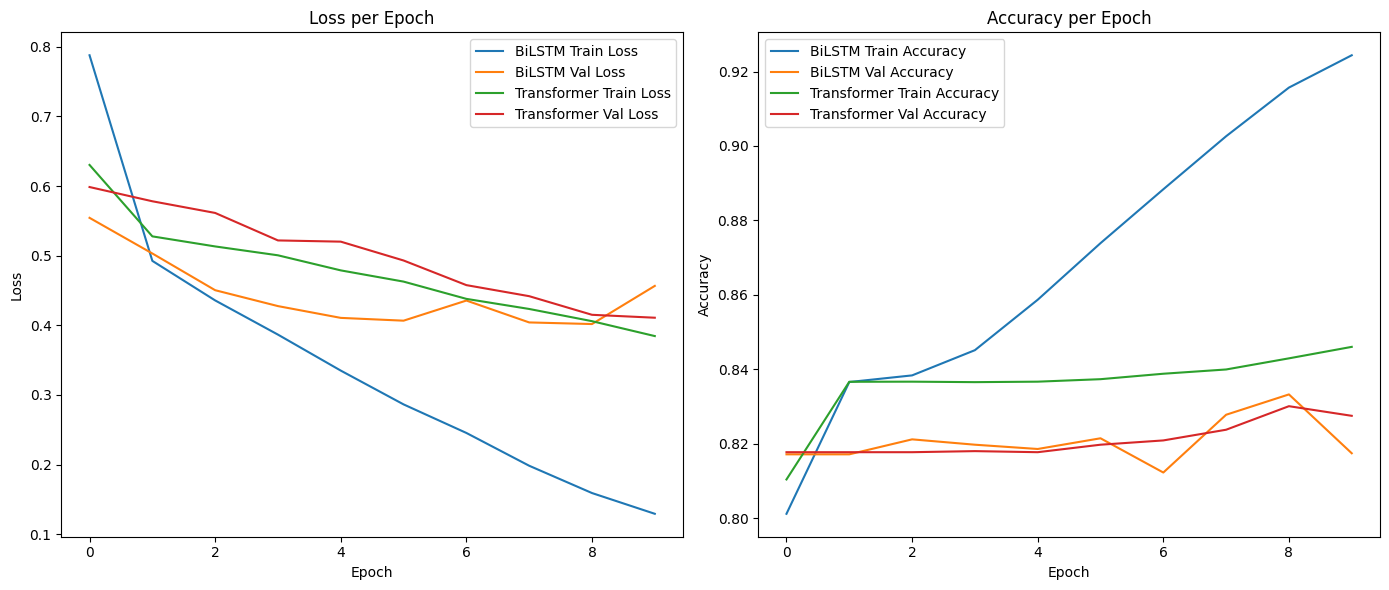

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))

# Plots Loss (Train + Validation)
plt.subplot(1, 2, 1)
plt.plot(lstm_train_loss, label='BiLSTM Train Loss')
plt.plot(lstm_val_loss, label='BiLSTM Val Loss')
plt.plot(transformer_train_loss, label='Transformer Train Loss')
plt.plot(transformer_val_loss, label='Transformer Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Plots Accuracy (Train + Validation)
plt.subplot(1, 2, 2)
plt.plot(lstm_train_acc, label='BiLSTM Train Accuracy')
plt.plot(lstm_val_acc, label='BiLSTM Val Accuracy')
plt.plot(transformer_train_acc, label='Transformer Train Accuracy')
plt.plot(transformer_val_acc, label='Transformer Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


---

# 3. **Evaluate models**

Here, you need to:

1.	evaluate the model (the best ones you obtained in the above stage).


In [ ]:
# Encodes test sentences and tags using the same vocabularies as training
encoded_test_sents, encoded_test_tags = encode_data(test_sentences, test_tags, word_vocab, tag_vocab)

# Creates test dataset using the encoded data
test_dataset = NERDataset(encoded_test_sents, encoded_test_tags)
# Creates a DataLoader to iterate over the test dataset in batches (no shuffling)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
# Prints the total number of test samples
print(f"Test dataset size: {len(test_dataset)}")


Test dataset size: 170


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, dataloader, tag_pad_idx, device):
    model.eval()  # Sets the model to evaluation mode
    criterion = nn.CrossEntropyLoss(ignore_index=tag_pad_idx)

    total_loss = 0.0
    total_correct = 0
    total_tokens = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, tags, lengths in dataloader:
            # Moves data to the device (GPU or CPU)
            inputs, tags = inputs.to(device), tags.to(device)

            # Forward pass to get logits
            logits = model(inputs, lengths)

            # Reshapes logits and tags for loss computation over all tokens
            logits_flat = logits.view(-1, logits.size(-1))
            tags_flat = tags.view(-1)
            loss = criterion(logits_flat, tags_flat)
            total_loss += loss.item()

            # predictions by taking the index with the highest score at each token
            predictions = logits.argmax(dim=-1)

            # Calculates accuracy and gathering predictions for each sample (ignoring pad tokens)
            for i, length in enumerate(lengths):
                pred_seq = predictions[i][:length].cpu().tolist()
                true_seq = tags[i][:length].cpu().tolist()
                all_preds.extend(pred_seq)
                all_labels.extend(true_seq)
                total_correct += sum(p == t for p, t in zip(pred_seq, true_seq))
                total_tokens += length

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0
    return avg_loss, accuracy, all_preds, all_labels

# Example evaluation of the BiLSTM model:
lstm_test_loss, lstm_test_acc, lstm_all_preds, lstm_all_labels = evaluate_model(lstm_model, test_loader, tag_pad_idx, device)

print(f"BiLSTM Test Loss: {lstm_test_loss:.4f}")
print(f"BiLSTM Test Accuracy: {lstm_test_acc:.4f}")





BiLSTM Test Loss: 0.4059
BiLSTM Test Accuracy: 0.8218


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report for BiLSTM Model:
              precision    recall  f1-score   support

       I-LOC       0.00      0.00      0.00       185
      I-MISC       0.57      0.09      0.16       132
       I-ORG       0.24      0.80      0.37       194
       I-PER       0.77      0.36      0.50       151
           O       0.94      0.92      0.93      3435

    accuracy                           0.82      4097
   macro avg       0.50      0.43      0.39      4097
weighted avg       0.84      0.82      0.82      4097



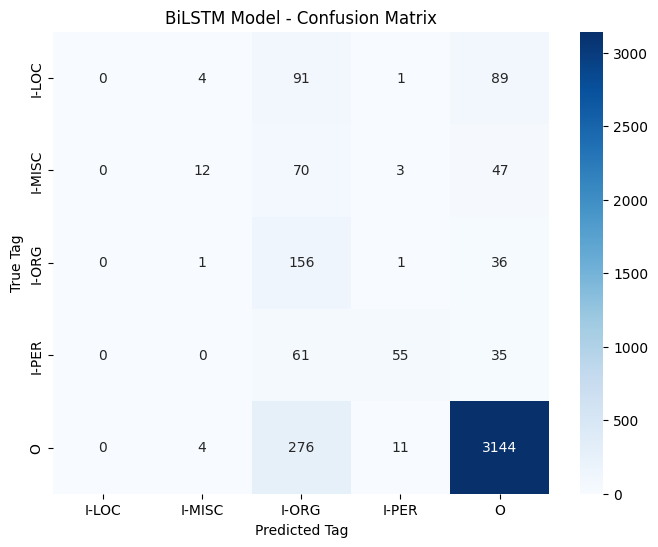

In [ ]:
# Sorts tag names by their corresponding indices for correct label alignment
sorted_tag_names = [tag for tag, idx in sorted(tag_vocab.items(), key=lambda x: x[1])]

# Generates classification report using true and predicted labels
report = classification_report(lstm_all_labels, lstm_all_preds, target_names=sorted_tag_names)
print("Classification Report for BiLSTM Model:")
print(report)

# Computes confusion matrix
cm = confusion_matrix(lstm_all_labels, lstm_all_preds)

# Plots the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=sorted_tag_names,
            yticklabels=sorted_tag_names)
plt.xlabel('Predicted Tag')
plt.ylabel('True Tag')
plt.title('BiLSTM Model - Confusion Matrix')
plt.show()
